In [1]:
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
import numpy as np
#import plot_utils
import matplotlib.pyplot as plt
from tqdm import tqdm
print('Tensorflow version:', tf.__version__)
#import imageio
#import glob

Tensorflow version: 2.2.0-dlenv


In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
x_train = x_train.astype(np.float32) / 255.0
x_test = x_test.astype(np.float32) / 255.0

4423680/4422102 [==============================] - 0s 0us/step


In [3]:
x_train.shape

(60000, 28, 28)

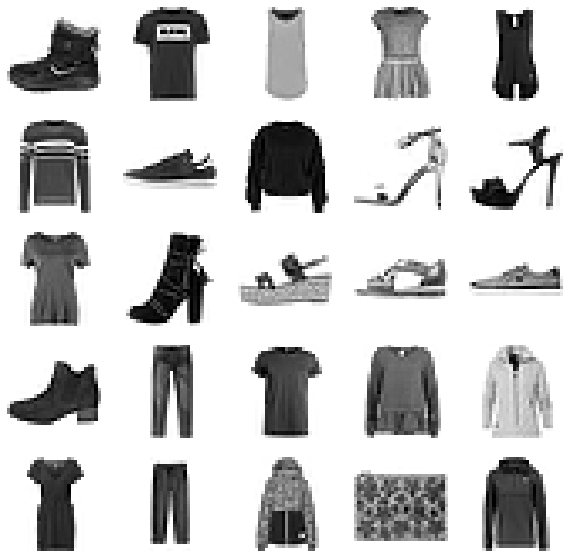

In [4]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.axis('off')
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
plt.show()

In [5]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

In [6]:
num_features = 100

generator = keras.models.Sequential([
    keras.layers.Dense(7 * 7 * 128, input_shape=[num_features]),
    keras.layers.Reshape([7, 7, 128]),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(128, (5,5), (1,1), padding="same", activation="selu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(64, (5,5), (2,2), padding="same", activation="selu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(1, (5,5), (2,2), padding="same", activation="tanh"),
])

TensorShape([1, 28, 28, 1])

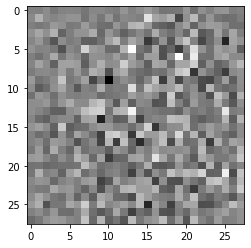

In [7]:
noise = tf.random.normal(shape=[1, num_features])
generated_images = generator(noise, training=False)
plt.imshow(generated_images[0, :, :, 0] * 127.5 + 127.5, cmap='binary')
generated_images.shape

In [8]:
discriminator = keras.models.Sequential([
    keras.layers.Conv2D(64, (5,5), (2,2), padding="same", input_shape=[28, 28, 1]),
    keras.layers.LeakyReLU(0.2),
    keras.layers.Dropout(0.3),
    keras.layers.Conv2D(128, (5,5), (2,2), padding="same"),
    keras.layers.LeakyReLU(0.2),
    keras.layers.Dropout(0.3),
    keras.layers.Conv2D(256, (5,5), (1,1), padding="same"),
    keras.layers.LeakyReLU(0.2),
    keras.layers.Dropout(0.3),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation='sigmoid')
])

In [9]:
decision = discriminator(generated_images)
print(decision)

tf.Tensor([[0.49956682]], shape=(1, 1), dtype=float32)


In [10]:
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan = keras.models.Sequential([generator, discriminator])
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

In [11]:
seed = tf.random.normal(shape=[batch_size, 100])

In [12]:
from IPython import display
def train_dcgan(gan, dataset, batch_size, num_features, epochs=5):
    generator, discriminator = gan.layers
    for epoch in tqdm(range(epochs)):
        print("Epoch {}/{}".format(epoch + 1, epochs))
        for X_batch in dataset:
            noise = tf.random.normal(shape=[batch_size, num_features])
            generated_images = generator(noise)
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            discriminator.trainable = True
            discriminator.train_on_batch(X_fake_and_real, y1)
            noise = tf.random.normal(shape=[batch_size, num_features])
            y2 = tf.constant([[1.]] * batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y2)
            # Produce images for the GIF as we go
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)
        
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

In [13]:
def generate_and_save_images(model, epoch, test_input):
    
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(10,10))

    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='binary')
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [14]:
x_train_dcgan = x_train.reshape(-1, 28, 28, 1) * 2. - 1.

In [15]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(x_train_dcgan)
dataset = dataset.shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

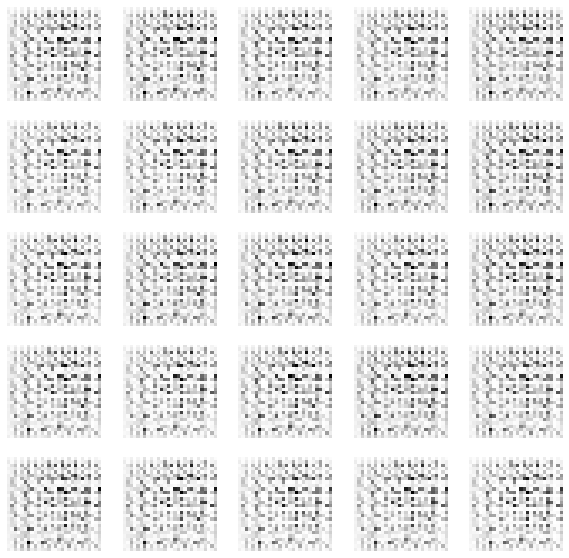

  2%|▏         | 1/50 [21:43<17:44:52, 1303.93s/it]

Epoch 2/50


In [ ]:
%%time
train_dcgan(gan, dataset, batch_size, num_features, epochs=50)